In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

# Comparing Two Samples

In [2]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


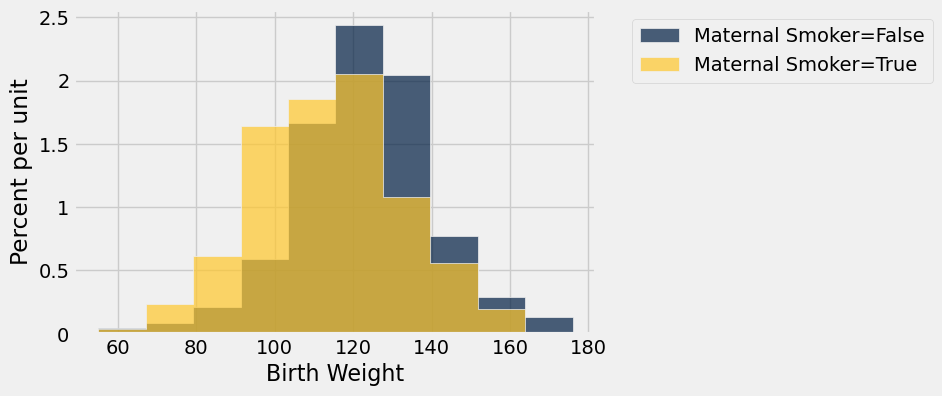

In [5]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

# Test Statistic

[Question] What values of our statistic are in favor of the alternative: positive or negative?

In [6]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [7]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [8]:
def difference_of_means(table, numeric_label, category_label):
    """
    Takes: 
       - name of table
       - column label of numerical variable
       - column label of categorical variable
       
    Returns: Difference of means of the two groups
    """
    
    #table with the two relevant columns
    reduced = table.select(numeric_label, category_label)  
    
    # table containing group means
    means_table = reduced.group(category_label, np.average)
    
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [9]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Random Permutation (Shuffling)

In [10]:
staff = Table().with_columns(
    'Names', make_array('Jim', 'Pam', 'Dwight', 'Michael'),
    'Ages', make_array(29, 28, 34, 41)
)
staff

Names,Ages
Jim,29
Pam,28
Dwight,34
Michael,41


In [11]:
staff.sample()

Names,Ages
Jim,29
Jim,29
Pam,28
Michael,41


In [12]:
staff.sample(with_replacement = False)

Names,Ages
Pam,28
Jim,29
Dwight,34
Michael,41


In [13]:
staff.with_column('Shuffled', staff.sample(with_replacement = False).column(0))

Names,Ages,Shuffled
Jim,29,Pam
Pam,28,Michael
Dwight,34,Dwight
Michael,41,Jim


# Simulation Under Null Hypothesis

In [14]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [15]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False).column('Maternal Smoker')
shuffled_labels

array([False, False,  True, ..., False, False,  True], dtype=bool)

In [16]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,False
True,128,True
True,108,True
False,136,False
False,138,False
False,132,False
False,120,False
True,143,False
False,140,False


In [17]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

0.26723037311273856

In [18]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Permutation Test

In [19]:
def one_simulated_difference(table, numeric_label, category_label):
    """
    Takes: 
       - name of table
       - column label of numerical variable
       - column label of categorical variable
       
    Returns: Difference of means of the two groups
    """
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False).column(category_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(numeric_label).with_column('Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, numeric_label, 'Shuffled Label')   

In [20]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

1.4334140804729003

In [21]:
differences = make_array()

for i in np.arange(1000):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


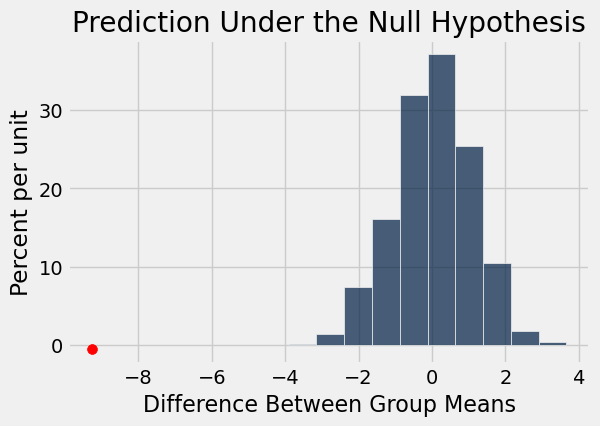

In [22]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');
plots.scatter(observed_difference, -0.005, color='red', s=50);

In [23]:
#observed_difference = -1.5
pvalue = sum(differences <= observed_difference)/len(differences)
pvalue

0.0